In [1]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
from helpers import *
from GAN import Generator, Discriminator

In [2]:
## Parameters ##

cudnn.benchmark = True

# Batch size during training
batch_size = 2048

# Original image size
image_size = 100

# Images will be downsampled to this spatial size
input_size = 32

# Number of channels in the training images
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 200

# Size of feature maps in generator
ngf = 128

# Size of feature maps in discriminator
ndf = int(ngf)

# Number of training epochs
num_epochs = 100

# Optimizer parameters
lr = 1e-5
beta1 = 0.9
beta2 = 0.999

# Number of training loops for critic/discriminator for each generator iteration
ncritic = 5

# Use 0 for CPU mode and > 0 for GPU.
ngpu = 1

device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")
print(device)

cuda:0


In [ ]:
##------------------------------------------------------------------------------------------------##
##  Data downloaded from CERN:                                                                    ##
##    ! curl https://cernbox.cern.ch/s/zZDKjltAcJW0RB7/download -o Data-ML-Jet-Project.tar.gz     ##
##------------------------------------------------------------------------------------------------##

In [3]:
## Fetch data for Colab ##

! curl https://cernbox.cern.ch/s/zZDKjltAcJW0RB7/download -o Data-ML-Jet-Project.tar.gz
! tar -xvzf Data-ML-Jet-Project.tar.gz
! ls Data-MLtutorial/JetDataset/
! rm Data-ML-Jet-Project.tar.gz

file_set = ['Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5',
            'Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5']

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  333M    0  333M    0     0  15.4M      0 --:--:--  0:00:21 --:--:-- 21.3M
Data-MLtutorial/
Data-MLtutorial/JetDataset/
Data-MLtutorial/JetDataset/jetImage_7_100p_0_10000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_10000_20000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_30000_40000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_40000_50000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_50000_60000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_60000_70000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_70000_80000.h5
Data-MLtutorial/JetDataset/jetImage_7_100p_80000_90000.h5
jetImage_7_100p_0_10000.h5	jetImage_7_100p_40000_50000.h5	jetImage_7_100p_70000_80000.h5
jetImage_7_100p_10000_20000.h5	jetImage_7_100p_50000_60000.h5	jetImage_7_100p_80000_90000.h5
jetImage_7_100p_30000_40000.h5	jetImage_7_100p_60000_70000.h5


In [ ]:
## Fetch data for local run ##

path = os.getcwd()
file_set = [path + '/Data/' + filename for filename in os.listdir(path = path + '/Data')]

In [17]:
## Process Data ##

images_numpy = np.concatenate([np.array(h5py.File(f).get('jetImage')) for f in file_set]).reshape(-1, nc, image_size, image_size)
float_images = images_numpy.astype('float32')

# Resize
tensor_images = torch.from_numpy(float_images)
resized_tensor_images = Resize(size=input_size)(tensor_images)
print("Dataset shape: ", resized_tensor_images.shape)

dataloader = torch.utils.data.DataLoader(resized_tensor_images, batch_size=batch_size, shuffle=True)


Dataset shape:  torch.Size([80000, 1, 32, 32])


In [3]:
# Initialize networks

netG = Generator(input_size=input_size, nc=nc, ngf=ngf, nz=nz).to(device)
netD = Discriminator(input_size=input_size, nc=nc, ndf=ndf).to(device)

print("Number of parameters (G): ", sum(p.numel() for p in netG.parameters()))
print("Number of parameters (D): ", sum(p.numel() for p in netD.parameters()))

# Set up optimizers

optimizerD = optim.Adam(netD.parameters(), lr= lr, betas=(beta1, beta2))
optimizerG = optim.Adam(netG.parameters(), lr= lr, betas=(beta1, beta2))

Number of parameters (G):  44983937
Number of parameters (D):  11140993


In [ ]:
## Training Loop ##

# Lists to keep track of progress
G_list = []
D_list = []

print("Starting Training Loop...")

# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        for p in netD.parameters(): # reset requires_grad
            p.requires_grad = True

        #----------------------------------#
        # Update D network 'ncritic' times #
        #----------------------------------#
        for j in range(ncritic):

            netD.zero_grad()

            # Forward pass real batch through D
            real_data = data.to(device)
            b_size = real_data.shape[0]
            output_real = netD(real_data)

            # Forward pass fake batch through D
            noise = torch.randn(b_size, nz, device=device)
            fake = netG(noise)
            output_fake = netD(fake)

            # Calculate gradient penalty
            grad_penalty = gradient_penalty(netD, real_data, fake, batch_size, device=device)

            # Calculate "loss"
            W = torch.mean(output_real - output_fake)
            errD = - W + grad_penalty
            errD.backward()
            # Update D
            optimizerD.step()

        #----------------------------------#
        #        Update G network          #
        #----------------------------------#
        for p in netD.parameters():
            p.requires_grad = False   # to avoid computation graph for discriminator parameters
        netG.zero_grad()

        # Forward and backward pass of new fake batch through D
        noise = torch.randn(b_size, nz, device=device)
        fake = netG(noise)
        output_fake = netD(fake)
        errG = - torch.mean(output_fake)
        errG.backward()
        # Update G
        optimizerG.step()

        # Save Losses for plotting later
        G_list.append(errG.item())
        D_list.append(errD.item())

    # Output training stats every epoch
    print('[%d/%d] \t \t Avg. D loss: %.4f \t Avg. G loss: %.4f' % (epoch, num_epochs, errD.item(), errG.item()))


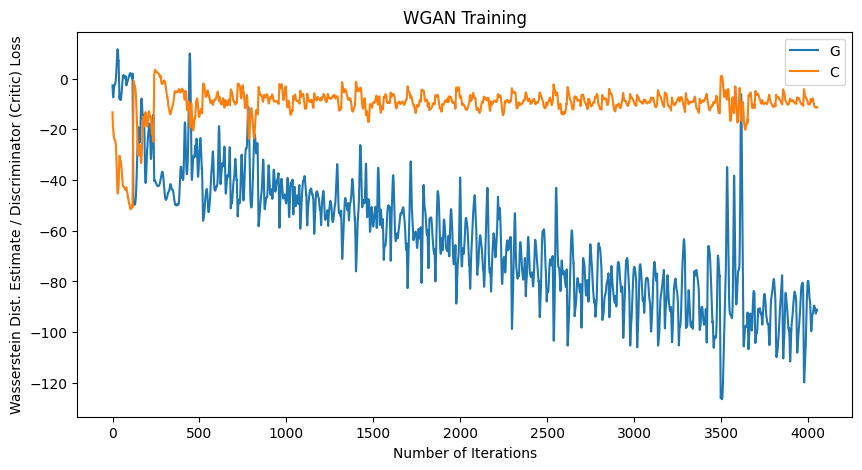

In [36]:
## Loss Plot, slightly smoothed ##

def moving_average(x, w=5):
    return np.convolve(x, np.ones(w), 'valid') / w

plt.figure(figsize=(10,5))
plt.title("WGAN Training")
plt.plot(moving_average(G_list, 5),label="G")
plt.plot(moving_average(D_list, 5),label="C")
plt.xlabel("Number of Iterations")
plt.ylabel("Wasserstein Dist. Estimate / Discriminator (Critic) Loss")
plt.legend()
plt.show()

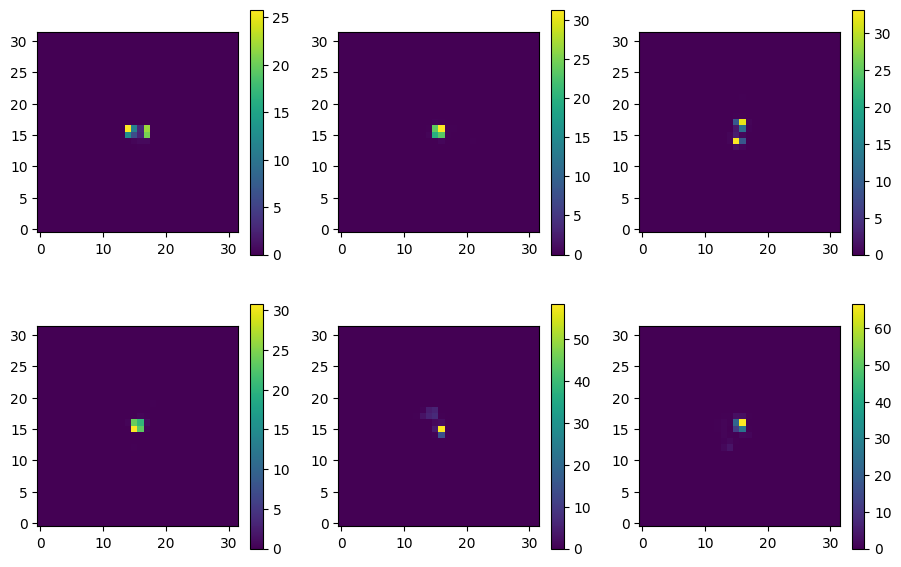

In [32]:
## Some real images ##

show_jets(resized_tensor_images)

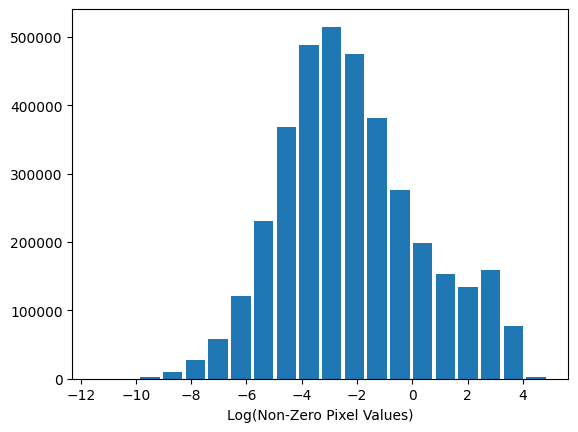

In [ ]:
## Distribution of pixel values for real images ##

show_hist(resized_tensor_images)

In [37]:
## Generating new images ##

noise = torch.randn(batch_size, nz, device=device)
gen_images = netG(noise)

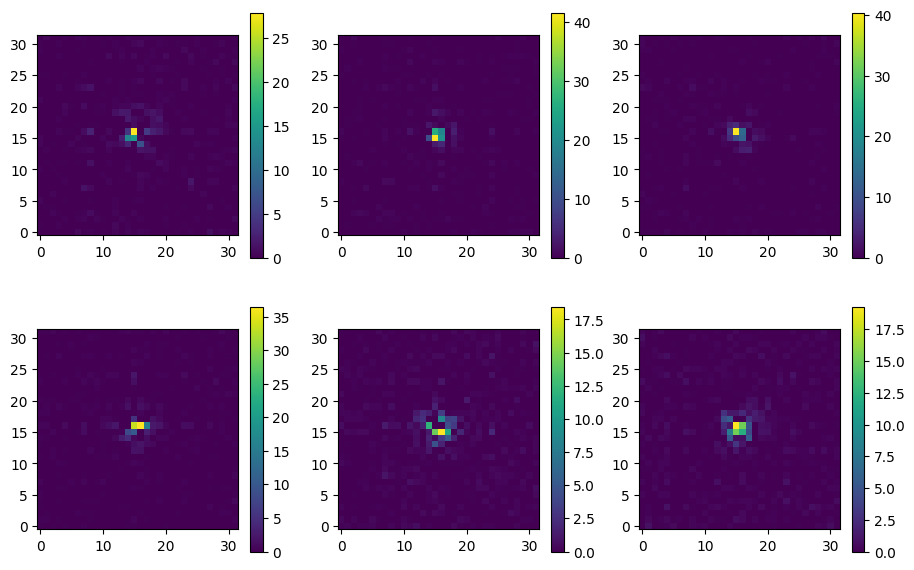

In [39]:
## Sample of generated new images ##

show_jets(filter(gen_images, threshold = 0.001))

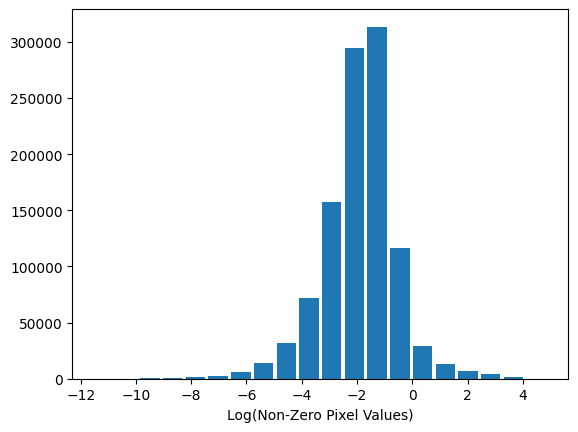

In [40]:
## Distribution of pixel values for generated images ##

show_hist(gen_images)

In [ ]:
## Download model from Google Colab ##

from google.colab import files

torch.save(netG.state_dict(), 'WGAN.pt')
files.download('WGAN.pt')